# NN design

Define and test some NN architectures and data vars. Train the models with the limited 21 day period of local data.

In [1]:
# 
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys

sys.path.append("../")
from src.processing import windsat_datacube, create_landmask


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 4GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/14)
    longitude       (day_number, longitude_grid, latitude_grid) float32 87MB dask.array<chunksize=(1, 1440, 720), meta=np.ndarray>
    latitude        (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    node            (day_number, swath_sector, latitude_grid, longitude_grid) float64 348MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    ...              ...
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) float64 348MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    landmask        (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

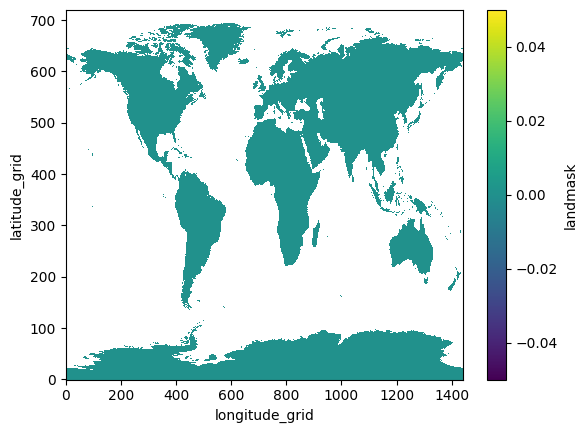

In [2]:
# Load the data in the folder
folder_path = "../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path=folder_path)
# Add the landmask and filter the dataset with only the land pixels

landmask = create_landmask(lat=ds.lat.values, lon=ds.lon.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds.landmask.attrs = {
    "Description": "Landmask object from regionmask, 0 for Land pixels, NaN for ocean"
}
ds.landmask.plot()

# Filter the ocean pixels
ds=ds.where(ds.landmask == 0)
ds

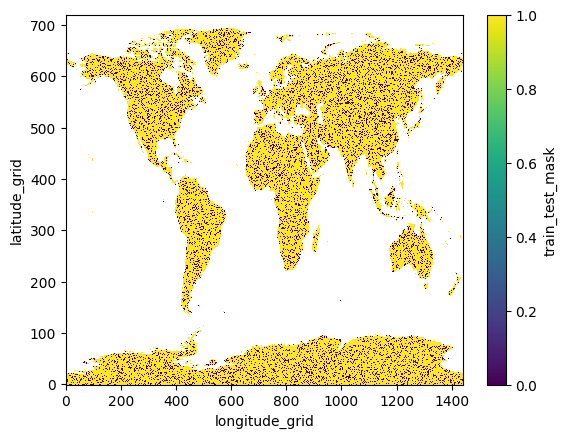

In [3]:
# Create the train-test mask
#TODO: Maybe worthit to wrap this into a function? 
land_indeces = np.argwhere(ds.landmask.values == 0)
train_indeces , test_indeces = train_test_split(land_indeces, test_size=0.2, random_state=13)
train_test_mask = np.copy(landmask)
train_test_mask[train_indeces[:,0], train_indeces[:,1]] = 1

ds["train_test_mask"] = (("latitude_grid", "longitude_grid"), train_test_mask)
ds.train_test_mask.attrs = {
    "Desccirption": "Random mask for train test split based on latitude and longitude (same for all days). Nan for Ocean, 0 for test, 1 for train"
}
ds.train_test_mask.plot()

In [4]:
# Separate the datastet( kind of redundant but is clearer for the user)
trainds = ds.where(ds.train_test_mask == 1)
testds = ds.where(ds.train_test_mask == 0)